In [1]:
import random
import math
import numpy as np
import cv2
from random import choice
import gym
from gym import Env, spaces
import stable_baselines3
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

In [2]:
#### COLORS (BGR)
BLUE =  [255, 0,   0]
GREEN = [0,   255, 0]
RED =   [0,   0,   255]
WHITE = [255, 255, 255]
GREY =  [240, 240, 240]
BLACK = [0,   0,   0]
PINK=   [255,20,147]


#### BUILDINGS
WASTELAND = 0
OFFICE    = 1
HOUSE     = 2
PARK     = 3
COMERC=4
INDU=5
COM=4
#### reset le programme quand il reste STOP cases vide
STOP = 4

In [49]:
# https://blog.paperspace.com/creating-custom-environments-openai-gym/
# https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e

class City(Env):
    def __init__(self, mapshape = (10, 10), start_shape = (3, 3)):
        super(City, self).__init__()
        
        self.HOUSE = HOUSE * max(mapshape)
        self.OFFICE = OFFICE * max(mapshape)
        self.park = PARK * max(mapshape)
        self.com = COMERC * max(mapshape)
        self.indu = INDU * max(mapshape)
        self.mapshape = mapshape
        self.observation_shape = (5,5)
        #self.observation_space = spaces.Box(low=0, high=6, shape=(5,5), dtype = int)#dtype=np.float16)
        self.observation_space = spaces.Box(low=0, high=5, shape=(5,5), dtype = int)#dtype=np.float16)
        self.start_shape = start_shape
        
        self.canvas_shape = 700, 700, 3 # width, height, color (BGR)
        self.canvas = np.ones(self.canvas_shape, dtype = np.uint8) * 0
        
        #self.action_space = spaces.Discrete(5)
        self.action_space = spaces.Discrete(4)
        # 
        self.is_placing_house = True
        
        # set the map
        self.map = np.ones(mapshape, dtype = np.uint8) * WASTELAND
        self.offices = []
        self.houses = []
        self.parks = []
        self.coms = []
        self.indus =[]
        self.adjacents_cells = {}
        #self.reward = 0.00001
        
        
        self.loop_number = 0
        self.start_size = start_shape[0]
        self.actual_size = 0
        self.actual_region = 0
        
        self.montrer=100
        self.itaration=0
        self.sum=0
        pass
    
    def reset(self, random_start = True):
        with open('./rewardDQN.txt', "a+") as fhandle:
              #for line in lines:
            fhandle.write(str(self.sum)+'\n')
        #print(self.sum)
        self.sum=0
        
        # reset the player's position in the middle of the map
        self.position = self.mapshape[0] // 2, self.mapshape[1] // 2
        

        self.is_placing_house = True
        
        # reset the map with WASTELAND
        self.map = np.ones(self.mapshape, dtype = np.uint8) * WASTELAND
        self.offices = []
        self.houses = []
        self.parks = []
        self.coms = []
        self.indus =[]
        self.adjacents_cells = {}
        #self.reward = 0.001
        
        self.loop_number = 0
        self.start_size = self.start_shape[0]
        self.actual_size = 0
        self.actual_region = 0
        
        
        start_shape = self.start_shape
        
        # (re)place random houses and offices in the middle of the map
        if random_start : 
            maisonX=([i for i in range((self.mapshape[1] - start_shape[1]) // 2, (self.mapshape[1] + start_shape[1]) // 2) if i !=(self.mapshape[1] // 2) ])
            maisonY=choice([i for i in range((self.mapshape[0] - start_shape[0]) // 2, (self.mapshape[0] + start_shape[0]) // 2) if i != (self.mapshape[0] // 2)])
            oficeX=choice([i for i in range((self.mapshape[1] - start_shape[1]) // 2, (self.mapshape[1] + start_shape[1]) // 2) if (i != maisonX) and (i!=(self.mapshape[1] // 2))])
            oficeY=choice([i for i in range((self.mapshape[0] - start_shape[0]) // 2, (self.mapshape[0] + start_shape[0]) // 2) if (i != maisonY) and (i!=(self.mapshape[0] // 2))])
            
            for y in range((self.mapshape[1] - start_shape[1]) // 2, (self.mapshape[1] + start_shape[1]) // 2):
                for x in range((self.mapshape[0] - start_shape[0]) // 2, (self.mapshape[0] + start_shape[0]) // 2):
                    g=random.randrange(2) + 1  #jaime bien aussi quand y a des terain vague ici pour laprentisage dumoin
                    if (y!=(self.mapshape[0] // 2) or (x!=(self.mapshape[1] // 2))):
                        self.map[y, x] = g
                        if x==maisonX and y==maisonY:
                            self.map[y, x] = HOUSE
                            self.houses.append((y, x))
                        elif x==oficeX and y==oficeY:
                            self.map[y, x] = OFFICE
                            self.offices.append((y, x))
                        elif self.map[y, x] == OFFICE : self.offices.append((y, x))
                        elif self.map[y, x] == HOUSE  : self.houses.append((y, x))
            
                        self.delete_cell((y, x))
                        self.mark_adjacents_cells((y, x))
                    #else:
                    #    print('ici')
                    #    print(x)
                    #    print(y)
                        
        
       # self.map[(self.observation_shape[0] // 2), (self.observation_shape[1] // 2)] = WASTELAND
    #self.position = 3, 3
        x0 = self.position[0]
        y0 = self.position[1]
        OBSMAP = self.getMap(self.map,x0,y0)
        self.vus=OBSMAP
    
        return OBSMAP
    
    def __search_nearest_office(self, position):
        return min([math.dist(position, office) for office in self.offices])

    def __search_nearest_Park(self, position):
        a=[math.dist(position, office) for office in self.parks]
        a.append(100)
        #print(min(a))
        return min(a)
    
    def __search_nearest_house(self, position):
        return min([math.dist(position, house) for house in self.houses])
    

    def __meanDistance(self,maap,Type):
        coord=np.argwhere(np.array(maap) == Type)
        if len(coord)>0:
            return np.mean(np.array([math.dist((2,2), truc) for truc in coord]))
        else:
            return 100
    
        
        
    def q__isTooMutchOffice(self,maap,Type):
        coord=len(np.argwhere(np.array(maap) == Type))
        coord0=len(np.argwhere(np.array(maap) == 0))
        if coord>(int((25-coord0)*0.3)+1):
        #if coord>3:
            return 4
        else:
            return -4

    def __isTooMutchOffice(self,maap,Type):
        coord=len(np.argwhere(np.array(maap) == Type))
        coord0=len(np.argwhere(np.array(maap) == 0))
        if coord>(int((25-coord0)*0.3)+1):
        #if coord>3:
            return 4
        else:
            return -4
    
    def __NbmaisonAdjasante(self,maap):
        
        maape=np.array(maap)#[]
        maape=maape[1:4,1:4]
        coord=np.argwhere(np.array(maape) == HOUSE)
        return len(coord)
    
    
    def __NbINDUadjasante(self,maap):
        
        maape=np.array(maap)#[]
        maape=maape[1:4,1:4]
        coord=np.argwhere(np.array(maape) == INDU)
        return len(coord)   
    
    def __NbmaisonAdjasantePARK(self,maap):
        
        maape=np.array(maap)#[]
        #maape=#maape[1:4,1:4]
        coord=np.argwhere(np.array(maape) == HOUSE)
        return len(coord) 
    def __NbmaisonAdjasanteINDU2(self,maap):
        
        maape=np.array(maap)#[]
        #maape=#maape[1:4,1:4]
        coord=np.argwhere(np.array(maape) == INDU)
        return len(coord)     
    
    # test if a position is occupied
    def __is_free(self, position):
        return self.map[position] == WASTELAND
    
    def delete_cell(self, position):
        try : del self.adjacents_cells[position]
        except KeyError : pass
    
    def mark_cell(self, position):
        y, x = position
        if x < 0 or x >= self.mapshape[0] : return
        if y < 0 or y >= self.mapshape[1] : return
        if tuple(position) in self.houses : return
        if tuple(position) in self.offices : return
        if tuple(position) in self.parks : return
        if tuple(position) in self.indus : return
        if tuple(position) in self.coms : return
        try :
            self.adjacents_cells[tuple(position)] += 1
        except KeyError :
            self.adjacents_cells[tuple(position)] = 1
    
    def mark_adjacents_cells(self, position):
        y, x = position
        for position in [[y - 1, x - 1], [y - 1, x], [y - 1, x + 1], [y, x - 1], [y, x + 1], [y + 1, x - 1], [y + 1, x], [y + 1, x + 1]] :
            self.mark_cell(position)
        pass
   
    def q__place(self,inpute,  is_placing_house):
        inpute=self.vus
        if is_placing_house==1 :
            # place the house


            # calculate the reward
            
            #reward = 1/(math.sqrt(self.__search_nearest_office(self.position)**2))
            r1 = self.__search_nearest_office(self.position)
            r1=1/(math.sqrt(r1**2))
            
            r2=self.__NbmaisonAdjasante(inpute)
            r2=r2/8
            
            r3=self.__meanDistance(inpute,COM)
            r3=1/(math.sqrt(r3**2))

            r4=self.__NbINDUadjasante(inpute)
            
            r5=self.__search_nearest_Park(self.position)
            if r5==100:
                r5=0
            else:
                r5=(1/r5)
            
            
            
            
            
            
            
            reward =(2*r1+r2+10*r3+3*r5)-10*r4
            

        elif is_placing_house==0 :
            # place the office

            
            
            r1=self.__meanDistance(inpute,HOUSE)
            r1=1/(math.sqrt(r1**2))
            
            
            
            
            #reward = 1/(math.sqrt(self.__search_nearest_house(self.position)**2))
            r2 = self.__search_nearest_office(self.position)
            r2=1/(math.sqrt(r2**2))
            
            div=self.__isTooMutchOffice(inpute,OFFICE)
            
            #traquer lerreur 497

            
            
            
            reward =(5*r1+r2)-(div)
            if r1>88:
                print(inpute)
                print(self.map)
                print(self.position)
            #reward =(5*r1+r2)/div
            
            #print('---')
           # print(r1)
            #print(r2)
          #  print(div)
          #  print(reward)

        elif is_placing_house==2:#park
            
            
            r1=self.__NbmaisonAdjasantePARK(inpute)
            
            
            reward=r1/5
            

            
        
        elif is_placing_house==3:#comercial
            
            r1=self.__NbmaisonAdjasante(inpute)
            
            
            reward=r1/2
            
            
            
  
            
        #elif is_placing_house==4:#indu
            
         #   r1=self.__NbmaisonAdjasante(inpute)
        #    r2=self.__NbmaisonAdjasanteINDU2(inpute)
         #   if r1==0 and r2<3:
        #        reward=10
        #    elif r1!=0 and r2<3:
        #        reward=-r1*2
        #    else:
        #        reward=-50

        return reward







    def __place(self, is_placing_house):
        inpute=self.vus
        if is_placing_house==1 :
            # place the house


            # calculate the reward
            
            #reward = 1/(math.sqrt(self.__search_nearest_office(self.position)**2))
            r1 = self.__search_nearest_office(self.position)
            r1=1/(math.sqrt(r1**2))
            
            r2=self.__NbmaisonAdjasante(inpute)
            r2=r2/8
            
            r3=self.__meanDistance(inpute,COM)
            r3=1/(math.sqrt(r3**2))

            r4=self.__NbINDUadjasante(inpute)

            
            
            
            
            r5=self.__search_nearest_Park(self.position)
            if r5==100:
                r5=0
            else:
                r5=(1/r5)
            
            
            
            
            reward =(2*r1+r2+10*r3+3*r5)-10*r4
            
            
            
            
            
            
            self.houses.append(self.position)
            self.map[self.position] = HOUSE
        elif is_placing_house==0 :
            # place the office

            
            
            r1=self.__meanDistance(inpute,HOUSE)
            r1=1/(math.sqrt(r1**2))
            
            
            
            
            #reward = 1/(math.sqrt(self.__search_nearest_house(self.position)**2))
            r2 = self.__search_nearest_office(self.position)
            r2=1/(math.sqrt(r2**2))
            
            div=self.__isTooMutchOffice(inpute,OFFICE)
            
            #traquer lerreur 497

            reward =(5*r1+r2)-(div)
            if r1>88:
                print(inpute)
                print(self.map)
                print(self.position)
            #reward =(5*r1+r2)/div
            
            #print('---')
           # print(r1)
            #print(r2)
          #  print(div)
          #  print(reward)
            
            self.offices.append(self.position)
            self.map[self.position] = OFFICE
        elif is_placing_house==2:#park
            
            
            r1=self.__NbmaisonAdjasantePARK(inpute)
            
            
            reward=r1/5
            
            self.parks.append(self.position)
            self.map[self.position] = PARK
            
        
        elif is_placing_house==3:#comercial
            
            r1=self.__NbmaisonAdjasante(inpute)
            
            
            reward=r1/2
            
            
            
            
            self.coms.append(self.position)
            self.map[self.position] = COMERC
            
     #   elif is_placing_house==4:#indu
            
    #        r1=self.__NbmaisonAdjasante(inpute)
   #         r2=self.__NbmaisonAdjasanteINDU2(inpute)
   #         if r1==0 and r2<3:
   #             reward=7.5#10?
    #        elif r1!=0 and r2<3:
    #            reward=-r1*2
     #       else:
     #           reward=-50
            
            
            
            
            
        #    self.indus.append(self.position)
        #    self.map[self.position] = INDU
        #reward = reward ** 2
        #reward = math.sqrt(reward)
        #reward = 1 / reward
        
        self.delete_cell(self.position)
        self.mark_adjacents_cells(self.position)
        self.sum=self.sum+reward
        return reward

    
    
    # test if a position if out of bound
    def __is_oob(self, position):
        return not(0 <= position[0] < self.mapshape[0]) \
            or not(0 <= position[1] < self.mapshape[1])
    
    def select_random_cell(self):
        for position in self.adjacents_cells :
            if self.adjacents_cells[position] >= 2 :
                return position
        return self.adjacents_cells[0]
    
    def select_next_cell(self):
        start_position = (self.mapshape[1] - self.start_size) // 2, (self.mapshape[0] - self.start_size) // 2
        start_position = start_position[0] - self.actual_size, start_position[1] - self.actual_size
        
        if self.actual_region == 0 :
            position = start_position[0] - 1,                                           start_position[1]
            position = position[0],                                                     position[1] + self.loop_number
        elif self.actual_region == 1 :
            position = start_position[0],                                               start_position[1] + self.start_size + self.actual_size * 2
            position = position[0] + self.loop_number,                                  position[1]
        elif self.actual_region == 2 :
            position = start_position[0] + self.start_size + self.actual_size * 2,      start_position[1] - 1 + self.start_size  + self.actual_size * 2
            position = position[0],                                                     position[1] - self.loop_number
        elif self.actual_region == 3 :
            position = start_position[0] - 1 + self.start_size + self.actual_size * 2,  start_position[1] - 1
            position = position[0] - self.loop_number,                                  position[1]
                
        self.loop_number += 1
        if self.loop_number > self.start_size + self.actual_size * 2 :
            self.loop_number = 0
            
            self.actual_region += 1
            if self.actual_region >= 4 :
                self.actual_region = 0
                self.actual_size += 1
                
        return position

    
    def step(self, action):
        #reward = 0
        #print(self.vus)
        
    
        reward = self.__place(action) # 1 = HOUSE / 0 = OFFICE
        self.reward = reward
        self.draw_elements_on_canvas()
        #print(self.vus)
        
        if len(self.adjacents_cells) < STOP + 1 :
            self.position = 0, 0#???????????
            x0 = self.position[0]
            y0 = self.position[1]
            OBSMAP = self.getMap(self.map,x0,y0)
            self.vus=OBSMAP
            
            
            self.itaration=self.itaration+1
           # if self.itaration>self.montrer:
            #    print(self.map)
           #     self.itaration=0
            return OBSMAP, reward, True, {}
        
        
        #print('---------')
       # print(self.vus)
        #print(reward) 
       # print(action)
        
        self.position = self.select_next_cell()
        x0=self.position[0]
        y0=self.position[1]
        OBSMAP=self.getMap(self.map,x0,y0)
        self.vus=OBSMAP
        

    
        
        return OBSMAP, reward, False, {}
    
    def getMap(self,mape,x,y):
        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value
        mape=np.pad(mape, 2, pad_with, padder=0)
        x=x+2
        y=y+2
        
        return mape[x-2:x+3,y-2:y+3]
        
        
        
        
    def __draw_element_on_canvas(self, y, x, color):
        observation_width, observation_height = self.mapshape
        canvas_width, canvas_height, _ = self.canvas_shape

        drawing_width = int(canvas_width / observation_width)
        drawing_height = int(canvas_height / observation_height)

        # fit element to the canvas
        for j in range(y * drawing_height, y * drawing_height + drawing_height):
            for i in range(x * drawing_width, x * drawing_width + drawing_width):
                try : self.canvas[i, j] = color
                except IndexError : 
                    print('error')
                    pass
                
        for j in range(y * drawing_height, y * drawing_height + drawing_height):
            try : self.canvas[x * drawing_width, j] = GREY
            except IndexError : pass
            
            
        for i in range(x * drawing_width, x * drawing_width + drawing_width):
            try : self.canvas[i, y * drawing_height] = GREY
            except IndexError : pass
        pass

    def __draw_area_position(self, thickness = 3): # thickness must be odd 
        SIZE = self.observation_shape[0] // 2
        
        y, x = self.position
        thickness_range = range(- (thickness // 2), thickness // 2 + 1)
        
        observation_width, observation_height = self.mapshape
        canvas_width, canvas_height, _ = self.canvas_shape

        drawing_width = int(canvas_width / observation_width)
        drawing_height = int(canvas_height / observation_height)
        
        for j in range((y - SIZE) * drawing_height, (y + SIZE) * drawing_height + drawing_height):
            try :
                for t in thickness_range:
                    self.canvas[(x - SIZE) * drawing_width + t, j] = BLACK
                    self.canvas[(x + SIZE + 1) * drawing_width + t, j] = BLACK
            except IndexError : pass

        for i in range((x - SIZE) * drawing_width, (x + SIZE) * drawing_width + drawing_width):
            try :
                for t in thickness_range:
                    self.canvas[i, (y - SIZE) * drawing_height + t] = BLACK
                    self.canvas[i, (y + SIZE + 1) * drawing_height + t] = BLACK
            except IndexError : pass
            
        pass
    
    def __draw_player_position(self, thickness = 3): # thickness must be odd 
        y, x = self.position
        thickness_range = range(- (thickness // 2), thickness // 2 + 1)
        
        observation_width, observation_height = self.mapshape
        canvas_width, canvas_height, _ = self.canvas_shape

        drawing_width = int(canvas_width / observation_width)
        drawing_height = int(canvas_height / observation_height)
        
        for j in range(y * drawing_height, y * drawing_height + drawing_height):
            try :
                for t in thickness_range:
                    self.canvas[x * drawing_width + t, j] = BLACK
                    self.canvas[(x + 1) * drawing_width + t, j] = BLACK
            except IndexError : pass

        for i in range(x * drawing_width, x * drawing_width + drawing_width):
            try :
                for t in thickness_range:
                    self.canvas[i, y * drawing_height + t] = BLACK
                    self.canvas[i, (y + 1) * drawing_height + t] = BLACK
            except IndexError : pass
            
        pass
    
    def draw_elements_on_canvas(self):
        
        # draw each element of the map
        for y in range(len(self.map)):
            for x in range(len(self.map[0])):
                
                color = WHITE
                if   self.map[y, x] == OFFICE : color = BLUE
                elif self.map[y, x] == HOUSE  : color = RED
                elif self.map[y, x] == PARK  : 
                    color = GREEN
                    #print(color)
                elif self.map[y, x] == COM  : 
                    color = [255,255,0]
                    #print(color)
                elif self.map[y, x] == INDU  : 
                    color = PINK
                    #print(color)
                
                self.__draw_element_on_canvas(y, x, color)
            pass
               
        # draw player's position
        self.__draw_player_position()
        self.__draw_area_position()
        pass
    
    def render(self, mode = "console"):
        if mode == "human" :
            #print(self.canvas)
            cv2.putText(self.canvas, str(self.reward), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow("", self.canvas)
            cv2.waitKey(1)
        if mode == "console" :
            print(self.position)
    
    def close(self):
        pass
    
    
    
    
    
    
    

In [50]:
'''#aleatoire
env = City((10, 10))
env.reset(random_start = True)

for _ in range(100):
    _, _, done, _ = env.step(env.action_space.sample())
    env.render("human")
    #faudrai aussi potenciellement suprimer les duplicata

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()'''

'#aleatoire\nenv = City((10, 10))\nenv.reset(random_start = True)\n\nfor _ in range(100):\n    _, _, done, _ = env.step(env.action_space.sample())\n    env.render("human")\n    #faudrai aussi potenciellement suprimer les duplicata\n\n    if done : env.reset()\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

In [51]:
'''
#aleatoire
env = City((5, 5))
env.reset(random_start = True)

for _ in range(10):
    _, _, done, _ = env.step(env.action_space.sample())
    env.render("human")
    #faudrai aussi potenciellement suprimer les duplicata

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()'''

'\n#aleatoire\nenv = City((5, 5))\nenv.reset(random_start = True)\n\nfor _ in range(10):\n    _, _, done, _ = env.step(env.action_space.sample())\n    env.render("human")\n    #faudrai aussi potenciellement suprimer les duplicata\n\n    if done : env.reset()\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

In [52]:
'''#prediction naive de maison
env = City((5, 5))
env.reset(random_start = True)

for _ in range(10):
    #print(env.vus)
    _, _, done, _ = env.step(1)
    env.render("human")
    #faudrai aussi potenciellement suprimer les duplicata

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()'''

'#prediction naive de maison\nenv = City((5, 5))\nenv.reset(random_start = True)\n\nfor _ in range(10):\n    #print(env.vus)\n    _, _, done, _ = env.step(1)\n    env.render("human")\n    #faudrai aussi potenciellement suprimer les duplicata\n\n    if done : env.reset()\ncv2.waitKey(0)\ncv2.destroyAllWindows()'

In [ ]:
#un peut plus compliquer
env = City((20, 20))
env.reset(random_start = True)

for _ in range(1000):
    #print(env.vus)#__place
    #if (env.q__place(env.vus,0)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,0)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,0)>=env.q__place(env.vus,3)) and (env.q__place(env.vus,0)>=env.q__place(env.vus,4)):
    if (env.q__place(env.vus,0)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,0)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,0)>=env.q__place(env.vus,3)):
    #if env.q__isTooMutchOffice(env.vus,OFFICE)==4:
        _, _, done, _ = env.step(0)
        #print(0)
    #elif (env.q__place(env.vus,1)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,1)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,1)>=env.q__place(env.vus,3)) and (env.q__place(env.vus,1)>=env.q__place(env.vus,4)):
    elif (env.q__place(env.vus,1)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,1)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,1)>=env.q__place(env.vus,3)):
        _, _, done, _ = env.step(1)
        #print(1)
    #elif (env.q__place(env.vus,2)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,2)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,2)>=env.q__place(env.vus,3)) and (env.q__place(env.vus,2)>=env.q__place(env.vus,4)):
    elif (env.q__place(env.vus,2)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,2)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,2)>=env.q__place(env.vus,3)):
        _, _, done, _ = env.step(2)
        #print(2)
    #elif (env.q__place(env.vus,3)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,3)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,3)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,3)>=env.q__place(env.vus,4)):
    elif (env.q__place(env.vus,3)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,3)>=env.q__place(env.vus,1)) and (env.q__place(env.vus,3)>=env.q__place(env.vus,2)):
        _, _, done, _ = env.step(3)
        #print(3)
    #elif (env.q__place(env.vus,4)>=env.q__place(env.vus,0)) and (env.q__place(env.vus,4)>=env.q__place(env.vus,2)) and (env.q__place(env.vus,4)>=env.q__place(env.vus,3)) and (env.q__place(env.vus,4)>=env.q__place(env.vus,1)):
  #      _, _, done, _ = env.step(4)
        #print(4)

    env.render("human")
    #faudrai aussi potenciellement suprimer les duplicata

    if done : env.reset()
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
'''from stable_baselines import SAC
from stable_baselines3.common.callbacks import CheckpointCallback
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./logs/',
                                         name_prefix='rl_model')

#model = SAC('MlpPolicy', 'Pendulum-v0')
#model.learn(2000, callback=checkpoint_callback)'''

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import tensorflow
from tensorflow.keras.layers import Conv2D
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
#env = City((5, 5), start_shape = (3, 3))
env = City((20, 20), start_shape = (3, 3))
env.observation_space.sample()
import tensorflow


import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


states = env.observation_space.shape
actions = env.action_space.n

def build_model(states, actions):
    model = tensorflow.keras.Sequential()    
    model.add(Dense(24, activation='relu', input_shape=((1,env.observation_shape[0], env.observation_shape[1]))))
    model.add(Dense(24, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear'))
    return model

model = build_model(states, actions)
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=10000, visualize=True, verbose=1)

Training for 10000 steps ...
Interval 1 (0 steps performed)


C:\Users\Valentin\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  311/10000 [..............................] - ETA: 1:26:54 - reward: 5.09823.6055512754639896


  621/10000 [>.............................] - ETA: 1:25:22 - reward: 4.11132.8284271247461903


  941/10000 [=>............................] - ETA: 1:22:46 - reward: 4.19882.8284271247461903


 1244/10000 [==>...........................] - ETA: 1:20:05 - reward: 4.40796.0827625302982185


 1544/10000 [===>..........................] - ETA: 1:17:20 - reward: 4.67755.099019513592785


 1878/10000 [====>.........................] - ETA: 1:14:19 - reward: 4.820711.0


 2042/10000 [=====>........................] - ETA: 1:12:52 - reward: 4.86671.4142135623730951


 2389/10000 [======>.......................] - ETA: 1:09:43 - reward: 4.97125.0


 2734/10000 [=======>......................] - ETA: 1:06:36 - reward: 5.0376100


 3102/10000 [========>.....................] - ETA: 1:03:15 - reward: 5.08848.54400374531753


 3441/10000 [=========>....................] - ETA: 1:00:10 - reward: 5.13023.0


 3782/10000 [==========>...................] - ETA: 57:02 - reward: 5.18724.0


 4158/10000 [===========>..................] - ETA: 53:36 - reward: 5.22845.385164807134505


 4490/10000 [============>.................] - ETA: 50:33 - reward: 5.295211.045361017187261


 4819/10000 [=============>................] - ETA: 47:31 - reward: 5.30781.0


 4887/10000 [=============>................] - ETA: 46:54 - reward: 5.3234

In [ ]:
#poutine

In [ ]:
import gym
import torch as th
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
#from stable_baselines3.deepq.policies import CnnPolicy
env = City((5, 5), start_shape = (3, 3))

model = DQN("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)
model.save("test")

In [ ]:
env = City((20, 20), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = PPO("MlpPolicy", env, batch_size=5, verbose=1)
model.learn(total_timesteps=10000)# tensorboard_log=log_dir)#, callback=callback)
#model.save("test")




Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 388      |
|    ep_rew_mean     | 1.52e+03 |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1033     |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 388        |
|    ep_rew_mean          | 1.65e+03   |
| time/                   |            |
|    fps                  | 1          |
|    iterations           | 2          |
|    time_elapsed         | 2079       |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01839177 |
|    clip_fraction        | 0.335      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.37      |
|    explained_variance   | -0.00431   |
|    learning_rate        | 

In [ ]:
env = City((20, 20), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2000,tb_log_name="first_run")# tensorboard_log=log_dir)#, callback=callback)
#model.save("test")

In [ ]:
#from stable_baselines3.deepq.policies import CnnPolicy
env = City((20, 20), start_shape = (3, 3))

model = DQN("MlpPolicy", env, verbose=1)
#model = DQN("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 388      |
|    ep_rew_mean      | 1.55e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 829      |
|    total_timesteps  | 1552     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 388      |
|    ep_rew_mean      | 1.5e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 1656     |
|    total_timesteps  | 3104     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 388      |
|    ep_rew_mean      | 1.53e+0

In [ ]:
###################analyse

In [ ]:
with open('rewardDQN.txt') as my_file:
    testsite_array = my_file.readlines()

In [ ]:
rewar=[]
for i in testsite_array:
    nombre=i[:-1]
    rewar.append(float(nombre))

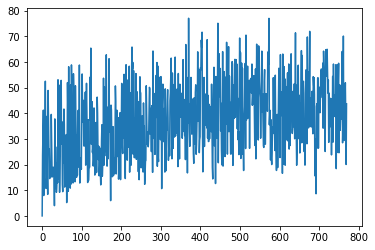

In [21]:
import matplotlib.pyplot as plt 
plt.plot(rewar)
plt.show()

In [22]:
with open('rewardOpti.txt') as my_file:
    testsite_array = my_file.readlines()

In [28]:
rewar=[]
for i in testsite_array:
    nombre=i[:-1]
    if float(nombre)<1000:
        rewar.append(float(nombre))

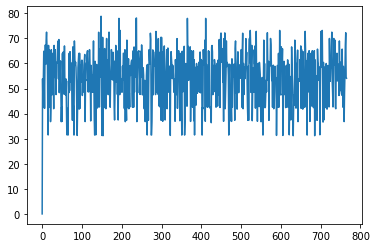

In [29]:
import matplotlib.pyplot as plt 
plt.plot(rewar)
plt.show()

In [ ]:

#from stable_baselines3.deepq.policies import CnnPolicy
env = City((5, 5), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = DQN("MlpPolicy", env, verbose=1)
#model = DQN('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
#model.save("test")

Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 25       |
|    total_timesteps  | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 10       |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 51       |
|    total_timesteps  | 104      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 3.33     |
|    exploration_rate | 0.852    |
| time/               |          |
|  

In [5]:
import gym
import torch as th
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)
#from stable_baselines3.deepq.policies import CnnPolicy
env = City((5, 5), start_shape = (3, 3))

model = DQN("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)
model.save("test")

In [ ]:
#from stable_baselines3.deepq.policies import CnnPolicy
env = City((5, 5), start_shape = (3, 3))

model = DQN("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000)
model.save("test")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 41.1     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 25       |
|    total_timesteps  | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 30       |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 50       |
|    total_timesteps  | 104      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 31.4   

In [42]:

#from stable_baselines3.deepq.policies import CnnPolicy
env = City((10, 10), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = DQN("MlpPolicy", env, verbose=1)
#model = DQN('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("test")

<class 'tuple'>


NotImplementedError: Nested observation spaces are not supported (Tuple/Dict space inside Tuple/Dict space).

In [25]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

#from stable_baselines.ddpg.policies import LnMlpPolicy
#from stable_baselines.bench import Monitor
#from stable_baselines.results_plotter import load_results, ts2xy
#from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
#from stable_baselines.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [21]:
log_dir = "./resultLog"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

In [22]:
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

In [ ]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DDPG LunarLander")

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


In [ ]:
plot_results(log_dir)

Using cpu device


In [ ]:
env = City((100, 100), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2000)# tensorboard_log=log_dir)#, callback=callback)
#model.save("test")

env = City((5, 5), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2000,tb_log_name="first_run")# tensorboard_log=log_dir)#, callback=callback)
#model.save("test")


In [ ]:
#trouver explication au diference de performanace

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.logger import configure

tmp_path = "./resultLog"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

#model = A2C("MlpPolicy", "CartPole-v1", verbose=1)
# Set new logger
model.set_logger(new_logger)
model.learn(total_timesteps=4000)

In [ ]:

    tensorboard_log_location = '.\\tensorboard\\'

    # Register the policy, it will check that the name is not already taken
    register_policy('CustomPolicy', CustomPolicyDetailed)

    env = Env_Tester()
    env = DummyVecEnv([lambda: env])
    tensorboard_log_location = '.\\tensorboard\\'

    TIMESTEPS = 1000000
    sched_LR = LinearSchedule(TIMESTEPS, 0.005, 0.00001)
    
    model = PPO2(policy ='CustomPolicy', 
                 env = env, 
                 verbose = 1, 
                 vf_coef = 1.0, 
                 noptepochs = 5, 
                 ent_coef = 0.005, 
                 learning_rate = sched_LR,
                 tensorboard_log = tensorboard_log_location,
                 n_steps = 8192, 
                 nminibatches = 128)

    model.learn(total_timesteps = TIMESTEPS)

In [28]:
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [ ]:
env = City((5, 5), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=4000)
#model.save("test")

Using cpu device


In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.logger import configure

tmp_path = "./resultLog"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

#model = A2C("MlpPolicy", "CartPole-v1", verbose=1)
# Set new logger
model.set_logger(new_logger)
model.learn(total_timesteps=4000)

In [ ]:
env = City((5, 5), start_shape = (3, 3))
env = make_vec_env(lambda: env, n_envs = 1)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=4000)
#model.save("test")

Using cpu device


In [ ]:
convolution

In [5]:
#bonus : utiliser tricks dans le cour du de la semaine du 7novembre, et putine